In [82]:
from numpy import load
import pickle
import scipy
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn import svm
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_learning_curves
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# Implements RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression


# Look into partial fitting. 
# Dataset is not evenly distributed with most being 1.
# Dummy Classifier has 50 % accuracy score... (Only give instances the most frequent label)



# steps_countvec = scipy.sparse.load_npz('recipe_text_features_countvec/train_steps_countvectorizer.pkl')

# Doc2Vect is a technique to transfer words into numerical representation. 
# https://www.shibumi-ai.com/post/a-gentle-introduction-to-doc2vec
d2v_ingr = pd.read_csv("../data/COMP30027_2021_Project2_datasets/recipe_text_features_doc2vec100/train_ingr_doc2vec100.csv", header=None)
d2v_name = pd.read_csv("../data/COMP30027_2021_Project2_datasets/recipe_text_features_doc2vec100/train_name_doc2vec100.csv", header=None)
d2v_steps = pd.read_csv("../data/COMP30027_2021_Project2_datasets/recipe_text_features_doc2vec100/train_steps_doc2vec100.csv", header=None)




# Extract class_labels from training set 
# quick = 1
# medium = 2
# slow = 3
data_train = pd.read_csv('../data/COMP30027_2021_Project2_datasets/recipe_train.csv')

# Obtain the labels
train_label = data_train.iloc[:,-1]




# Feature selection with f_classif (ANOVA F-value)
# ANOVA f-value shows how well a feature discriminate between classes
# The more discrimination, the better that feature is in predicting the class label.
# d2v_name_new = SelectKBest(k=90).fit_transform(d2v_name, train_label)
# d2v_ingr_new = SelectKBest(k=90).fit_transform(d2v_ingr, train_label)
# d2v_steps_new = SelectKBest(k=90).fit_transform(d2v_steps, train_label)
d2v_name_new = pd.DataFrame(d2v_name)
d2v_ingr_new = pd.DataFrame(d2v_ingr)
d2v_steps_new = pd.DataFrame(d2v_steps)
# print(d2v_ingr_new)
# print(d2v_steps_new)
# print(d2v_name_new.shape)


# Create a new dataframe of data, but this time, name, steps and ingr has been engineered to have doc2vec features.
# 100 doc2vec features were given, but we selected 20 best features using ANOVA f-value.
f_data = d2v_name_new.join(data_train.iloc[:,1:3], on=None, how='left', lsuffix='_left', rsuffix='_right')
f_data = d2v_name_new.join(d2v_steps_new, on=None, how='left', lsuffix='_left', rsuffix='_right')
f_data = f_data.join(d2v_ingr_new, on=None, how='left', lsuffix='_left', rsuffix='_right')


# # Standardise the data so that the mean is 0
# scaler = StandardScaler()
# f_data = scaler.fit_transform(f_data)

# normalise all values to be between 0 and 1
minmax_scaler = MinMaxScaler()
f_data = minmax_scaler.fit_transform(f_data)
   
        
           


# # Oversampling, because the distribution of classes in training data is highly skewed towards quick and medium.
# oversample = RandomOverSampler(sampling_strategy='minority')

# # First random oversampling, bring count of class 3 to be equal to the highest class count.
# X_oversampled, y_oversampled = oversample.fit_resample(f_data, train_label)

# # Second random oversampling, bring the count of class 2 to be equal to the other 2 classes
# X_oversampled, y_oversampled = oversample.fit_resample(X_oversampled, y_oversampled)





# Splitting the provided training into its own train/test
X_train, X_test, y_train, y_test = train_test_split(f_data, train_label, test_size=0.3, stratify=train_label, random_state=42)
smote = SMOTE(random_state=42)
smX, smY = smote.fit_resample(X_train, y_train)

mi = SelectKBest(mutual_info_classif, k=60)
smX = select.fit_transform(smX, smY)
X_test = select.transform(X_test)




smY.value_counts()
smX = pd.DataFrame(smX)
X_test.shape, y_test.shape

((12000, 60), (12000,))

### Random Forest Classifier

In [ ]:

# Rd_Forest_clf = RandomForestClassifier(n_jobs = -1, random_state = 0)




# # Grid search
# param_grid = { 
#     'n_estimators': [200, 500],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [4,5,6,7,8],
#     'criterion' :['gini', 'entropy']
# }
# CV_rfc = RandomizedSearchCV(estimator=Rd_Forest_clf, param_distributions =param_grid, n_iter=10, cv= 4, random_state=0, n_jobs = -1)
# CV_rfc.fit(X_train, y_train)
# CV_rfc.best_params_



In [77]:
forest = RandomForestClassifier(n_estimators=1000, max_features='log2', max_depth=6, 
                                criterion='entropy', n_jobs = -1, random_state = 0)
forest.fit(smX, smY)
Forest_pred = forest.predict(X_test)
Forest_train_pred = forest.predict(smX)
# Check accuracy of Random Forest
print('test:', accuracy_score(y_test, Forest_pred))
print('train:', accuracy_score(smY, Forest_train_pred))
print(classification_report(y_test, Forest_pred))

test: 0.56425
train: 0.6681014206416408
              precision    recall  f1-score   support

         1.0       0.64      0.42      0.51      5311
         2.0       0.65      0.69      0.67      6074
         3.0       0.17      0.58      0.27       615

    accuracy                           0.56     12000
   macro avg       0.49      0.56      0.48     12000
weighted avg       0.62      0.56      0.58     12000



In [32]:
test_y = []
train_y = []

for depth in range(1,11):
    forest = RandomForestClassifier(n_estimators=500, max_features='log2', max_depth=depth, 
                                criterion='entropy', n_jobs = -1, random_state = 0)
    
    forest.fit(X_train, y_train)
    Forest_pred = forest.predict(X_test)
    Forest_train_pred = forest.predict(X_train)
    
    test_y.append(accuracy_score(y_test, Forest_pred))
    train_y.append(accuracy_score(y_train, Forest_train_pred))
    
    
    


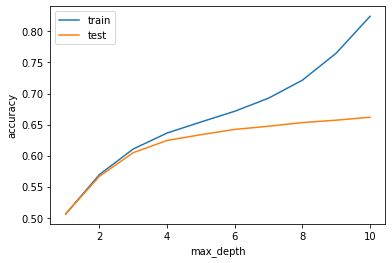

In [36]:
depth = [1,2,3,4,5,6,7,8,9,10]

plt.plot(depth, train_y, label = "train")
plt.plot(depth, test_y, label = "test")
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [86]:
# Dummy Classifier
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy='stratified', random_state = 0)
dummy_clf.fit(smX, smY)
dummy_pred = dummy_clf.predict(X_test)
# Check accuracy of Dummy
print(accuracy_score(y_test, dummy_pred))

0.3315


### SVM

In [78]:
# # Plot learning curve


# LinearSVC = svm.LinearSVC(dual=False, multi_class='ovr', random_state=0)
# SVC_clf = make_pipeline(MinMaxScaler(), LinearSVC)
SVC_clf = svm.LinearSVC(dual=False, multi_class='ovr', random_state=0)
# plot_learning_curves(smX, smY, X_test, y_test, SVC_clf, scoring= 'accuracy')
# plt.show()
# Implementing LinearSVM from sklearn library
# Similar to SVC with parameter kernel=’linear’, 
# scale better to large numbers of samples.
# supports both dense and sparse input
# multiclass support is handled according to a one-vs-the-rest scheme.
# The more features the better
from sklearn.pipeline import make_pipeline
# LinearSVC = svm.LinearSVC(dual=False, multi_class='ovr', random_state=0)

SVC_clf.fit(smX, smY)

y_test_predict = SVC_clf.predict(X_test)
y_train_predict = SVC_clf.predict(smX)
# np.save('y_predict_name_sparse.npy', y_test_predict)
print("test", accuracy_score(y_test, y_test_predict))
print("train", accuracy_score(smY, y_train_predict))
# print(LinearSVC_clf.score(X_test, y_test))




# 0 score for precision, recall and f1 on class label 3...
print(classification_report(y_test, y_test_predict))
cm = confusion_matrix(y_test, y_test_predict)
cm

test 0.5641666666666667
train 0.65191927744849
              precision    recall  f1-score   support

         1.0       0.64      0.59      0.61      5311
         2.0       0.69      0.53      0.60      6074
         3.0       0.18      0.72      0.28       615

    accuracy                           0.56     12000
   macro avg       0.50      0.61      0.50     12000
weighted avg       0.64      0.56      0.59     12000



array([[3137, 1330,  844],
       [1667, 3193, 1214],
       [  96,   79,  440]], dtype=int64)

### AdaBoost

In [81]:
Adaboost = AdaBoostClassifier(n_estimators=100, random_state=0)
Adaboost.fit(smX, smY)
Adaboost_pred = Adaboost.predict(X_test)
Adaboost_train_pred = Adaboost.predict(smX)
# Check accuracy of AdaBoost
print(accuracy_score(y_test, Adaboost_pred))
print(accuracy_score(smY, Adaboost_train_pred))
print(classification_report(y_test, Adaboost_pred))

0.56325
0.656270580487346
              precision    recall  f1-score   support

         1.0       0.62      0.54      0.58      5311
         2.0       0.65      0.58      0.62      6074
         3.0       0.18      0.55      0.27       615

    accuracy                           0.56     12000
   macro avg       0.48      0.56      0.49     12000
weighted avg       0.61      0.56      0.58     12000



### Stacking

In [ ]:
# https://www.analyticsvidhya.com/blog/2020/10/how-to-use-stacking-to-choose-the-best-possible-algorithm/

In [87]:
estimators = [
     ('LinearSVC', SVC_clf),
     ('Random Forest', forest),
    ('dummy_clf', dummy_clf),
    ('Adaboost', Adaboost)]


stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(n_jobs=6, random_state=0), n_jobs=6)
stacking_clf.fit(smX, smY)
stacking_y_pred = stacking_clf.predict(X_test)
stacking_y_train_predict = stacking_clf.predict(X_train)

print(accuracy_score(y_test, stacking_y_pred))
print(accuracy_score(y_oversampled, y_train_predict_stack))
print(classification_report(y_test, stacking_y_train_predict))
cm = confusion_matrix(y_test, stacking_y_pred)
cm

ValueError: X has 300 features per sample; expecting 60